In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools

In [2]:
filename = 'NSEI'
df = pd.read_csv(filename + '.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date'])

In [3]:
df = df[(df['Date'].dt.dayofweek !=5) &(df['Date'].dt.dayofweek) !=6]
df = df.dropna(axis=0, how='all', subset=df.columns[1:])
df = df.sort_values(['Date'])

In [4]:
closing_prices = df["Close"]

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Reshape

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.values.reshape(-1, 1))
# Divide data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:, :]
test_data_index = closing_prices[train_size:].index


In [7]:
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        data_x.append(dataset[i:(i + window_size), 0])
        data_y.append(dataset[i + window_size, 0])
    return np.array(data_x), np.array(data_y)

In [8]:
window_size = 5
train_x, train_y = create_dataset(train_data, window_size)
test_x, test_y = create_dataset(test_data, window_size)
# Reshape input to [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [9]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# Reshape the output to match LSTM input shape
model.add(Reshape((window_size // 2, 64 // (window_size // 2))))  # Adjust as necessary based on pooling and conv layers

# Add LSTM layer
model.add(LSTM(50))

# Add Dense layer
model.add(Dense(1))


# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[2], train_x.shape[1]))


In [11]:
import tensorflow as tf


@tf.function
def train_step(train_x, train_y):
    with tf.GradientTape() as tape:
        predictions = model(train_x, training=True)
        loss = model.compiled_loss(train_y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

for epoch in range(100):
    loss = train_step(train_x, train_y)
    print("Epoch {}: Loss: {}".format(epoch, loss))

Epoch 0: Loss: 0.07376997172832489
Epoch 1: Loss: 0.06934322416782379
Epoch 2: Loss: 0.06499691307544708
Epoch 3: Loss: 0.06073600426316261
Epoch 4: Loss: 0.05655639246106148
Epoch 5: Loss: 0.05244822800159454
Epoch 6: Loss: 0.04841243475675583
Epoch 7: Loss: 0.04445482790470123
Epoch 8: Loss: 0.04058312252163887
Epoch 9: Loss: 0.036807239055633545
Epoch 10: Loss: 0.033138979226350784
Epoch 11: Loss: 0.02959214150905609
Epoch 12: Loss: 0.026189565658569336
Epoch 13: Loss: 0.02295493148267269
Epoch 14: Loss: 0.019913537427783012
Epoch 15: Loss: 0.017090803012251854
Epoch 16: Loss: 0.014515028335154057
Epoch 17: Loss: 0.012216253206133842
Epoch 18: Loss: 0.010221870616078377
Epoch 19: Loss: 0.008555862121284008
Epoch 20: Loss: 0.007238691672682762
Epoch 21: Loss: 0.006282564718276262
Epoch 22: Loss: 0.005686610471457243
Epoch 23: Loss: 0.005432141479104757
Epoch 24: Loss: 0.0054784719832241535
Epoch 25: Loss: 0.005761143285781145
Epoch 26: Loss: 0.0061948285438120365
Epoch 27: Loss: 0.00

In [12]:
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[2], test_x.shape[1]))

In [13]:
loss = model.evaluate(test_x, test_y)
print("Test Loss:", loss)

25/25 [==============================] - 1s 1ms/step - loss: 3.6387e-04
Test Loss: 0.0003638742200564593


In [14]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

# Revert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform(train_y.reshape(-1, 1))  # Reshape train_y if necessary
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform(test_y.reshape(-1, 1))

In [15]:
train_rmse = np.sqrt(mean_squared_error(train_y, train_predict))
print("Train RMSE:", train_rmse)

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_y, test_predict))
print("Test RMSE:", test_rmse)

Train RMSE: 412.76499857690294
Test RMSE: 373.36905473884036


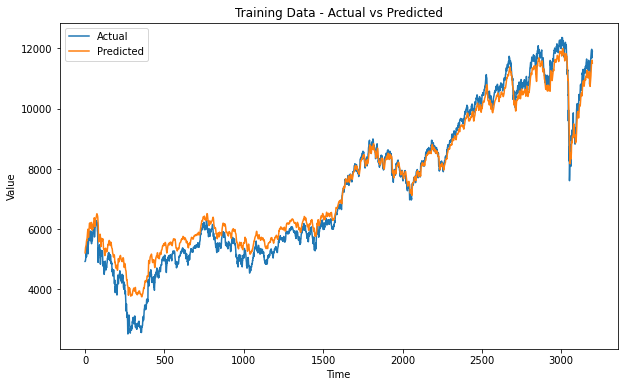

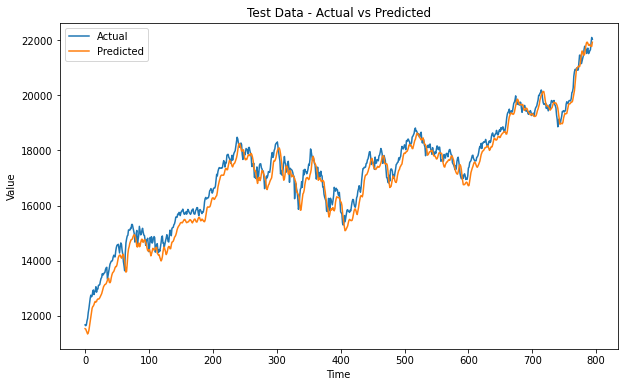

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(train_y, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot test data
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Test Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()